## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
!pip install -U torch torchvision

In [3]:
from os.path import exists
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:

import numpy as np
print(torch.version.cuda)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

10.2
CUDA is available!  Training on GPU ...


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [7]:
!unzip -q /content/gdrive/My\ Drive/data.zip -d dogs

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [9]:
# define modes of datasets
DATA_MODES = ['train', 'val', 'test']
# define the size of image
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

Предобработка данных + аугментации для тренировочной выборки

In [45]:
class DogDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # transforming images to tensors
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_train =  transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            #transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=180),
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'test':
            x = transform_test(x)
            return x
        else:
            if self.mode == 'val':
                x = transform_test(x)
            else:
                x = transform_train(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
TRAIN_DIR = Path("/content/dogs/data/train")
TEST_DIR = Path("/content/dogs/data/test")


train_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))
print(test_files)
print(train_files)


[PosixPath('/content/dogs/data/test/0.jpeg'), PosixPath('/content/dogs/data/test/1.jpeg'), PosixPath('/content/dogs/data/test/10.jpeg'), PosixPath('/content/dogs/data/test/100.jpeg'), PosixPath('/content/dogs/data/test/1000.jpeg'), PosixPath('/content/dogs/data/test/1001.jpeg'), PosixPath('/content/dogs/data/test/1002.jpeg'), PosixPath('/content/dogs/data/test/1003.jpeg'), PosixPath('/content/dogs/data/test/1004.jpeg'), PosixPath('/content/dogs/data/test/1005.jpeg'), PosixPath('/content/dogs/data/test/1006.jpeg'), PosixPath('/content/dogs/data/test/1007.jpeg'), PosixPath('/content/dogs/data/test/1008.jpeg'), PosixPath('/content/dogs/data/test/1009.jpeg'), PosixPath('/content/dogs/data/test/101.jpeg'), PosixPath('/content/dogs/data/test/1010.jpeg'), PosixPath('/content/dogs/data/test/1011.jpeg'), PosixPath('/content/dogs/data/test/1012.jpeg'), PosixPath('/content/dogs/data/test/1013.jpeg'), PosixPath('/content/dogs/data/test/1014.jpeg'), PosixPath('/content/dogs/data/test/1015.jpeg'), P

In [23]:
print(len(train_files))

7166


In [19]:
test_dataset = DogDataset(test_files, mode='val')

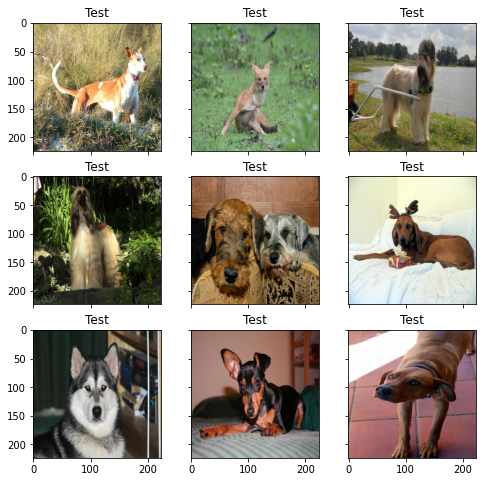

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), 
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,300))
    im_val, label = test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
              test_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), 
          title=img_label,plt_ax=fig_x)

Transfer learning

In [27]:
import torchvision.models as models

Хочу, чтобы обучались параметры fc слоя и 4го сверточного, а параметры остальынх слоев оставались зафиксированными - параметрами предобученной сетки

In [28]:
model_1 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_1.parameters():
    param.requires_grad = False
for param in model_1.layer4.parameters():
    param.requires_grad = True  

model_1.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 50)
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [29]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data

    if scheduler is not None:
        scheduler.step()
    return train_loss, train_acc

In [30]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [31]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import AdamW

In [38]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = AdamW(model.parameters(), lr=0.0005)
        scheduler = ExponentialLR(optimizer=opt, gamma=0.85)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            
    return history

In [33]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [34]:
#n_classes = len(np.unique(train_labels))
my_cnn_1 = model_1.to(DEVICE)
print("we will classify :{}".format(50))
print(my_cnn_1)

we will classify :50
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

In [36]:
if test_dataset is None:
    test_dataset = DogDataset(test_files, mode='val')
    
train_dataset = DogDataset(train_files, mode='train')

Валидационную выборку не использую для отслеживания обучения, для нее были некорректные лейблы

In [39]:
history = train(train_dataset, test_dataset, model=my_cnn_1, epochs=15, batch_size=48)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.059063087386723


epoch:   7%|▋         | 1/15 [02:54<40:47, 174.82s/it]


Epoch 001 train_loss: 2.0591     val_loss 7.9110 train_acc 0.4468 val_acc 0.0233
loss 1.6559282567226252


epoch:  13%|█▎        | 2/15 [05:43<37:09, 171.48s/it]


Epoch 002 train_loss: 1.6559     val_loss 10.0086 train_acc 0.5116 val_acc 0.0146
loss 1.1358178478028567


epoch:  20%|██        | 3/15 [08:29<33:43, 168.63s/it]


Epoch 003 train_loss: 1.1358     val_loss 10.5746 train_acc 0.6536 val_acc 0.0186
loss 1.011644293717622


epoch:  27%|██▋       | 4/15 [11:12<30:32, 166.63s/it]


Epoch 004 train_loss: 1.0116     val_loss 11.6782 train_acc 0.6860 val_acc 0.0240
loss 0.8003357951780155


epoch:  33%|███▎      | 5/15 [13:57<27:39, 165.92s/it]


Epoch 005 train_loss: 0.8003     val_loss 11.5070 train_acc 0.7476 val_acc 0.0539
loss 0.7195219417507343


epoch:  40%|████      | 6/15 [16:51<25:17, 168.57s/it]


Epoch 006 train_loss: 0.7195     val_loss 12.9262 train_acc 0.7785 val_acc 0.0186
loss 0.6391490230239573


epoch:  47%|████▋     | 7/15 [19:38<22:24, 168.06s/it]


Epoch 007 train_loss: 0.6391     val_loss 13.1640 train_acc 0.7974 val_acc 0.0273
loss 0.5528562754109823


epoch:  53%|█████▎    | 8/15 [22:16<19:13, 164.83s/it]


Epoch 008 train_loss: 0.5529     val_loss 14.2916 train_acc 0.8215 val_acc 0.0240
loss 0.49992357957572736


epoch:  60%|██████    | 9/15 [24:56<16:20, 163.36s/it]


Epoch 009 train_loss: 0.4999     val_loss 14.3129 train_acc 0.8413 val_acc 0.0253
loss 0.4427284020603019


epoch:  67%|██████▋   | 10/15 [27:35<13:30, 162.12s/it]


Epoch 010 train_loss: 0.4427     val_loss 14.7058 train_acc 0.8525 val_acc 0.0279
loss 0.400479717125548


epoch:  73%|███████▎  | 11/15 [30:15<10:45, 161.35s/it]


Epoch 011 train_loss: 0.4005     val_loss 15.6109 train_acc 0.8692 val_acc 0.0266
loss 0.35172509932913926


epoch:  80%|████████  | 12/15 [32:57<08:04, 161.63s/it]


Epoch 012 train_loss: 0.3517     val_loss 17.0746 train_acc 0.8861 val_acc 0.0240
loss 0.326439957494946


epoch:  87%|████████▋ | 13/15 [35:37<05:22, 161.03s/it]


Epoch 013 train_loss: 0.3264     val_loss 16.9636 train_acc 0.8945 val_acc 0.0246
loss 0.2837230750478382


epoch:  93%|█████████▎| 14/15 [38:17<02:40, 160.96s/it]


Epoch 014 train_loss: 0.2837     val_loss 17.9079 train_acc 0.9082 val_acc 0.0259
loss 0.26041403231908916


epoch: 100%|██████████| 15/15 [40:58<00:00, 163.89s/it]


Epoch 015 train_loss: 0.2604     val_loss 18.5390 train_acc 0.9145 val_acc 0.0246


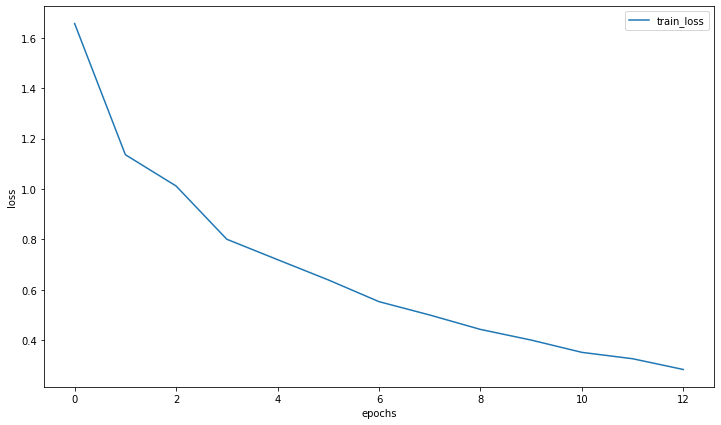

In [41]:
plt.figure(figsize=(12, 7))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss[1:-1:], label="train_loss")
#plt.plot(acc[1:-1:], label="train_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

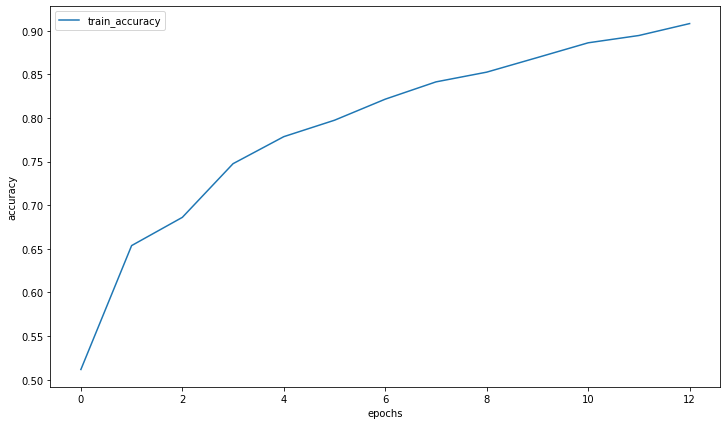

In [58]:
plt.figure(figsize=(12, 7))
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(acc[1:-1:], label="train_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [59]:
def predict_one_sample(model, inputs, device=DEVICE):
# precision for 1 picture
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Посмотрю, какие лейблы и с какой уверенностью модель предсказывает на сэмплах из тестовой выборки. Если бы названия классов были осмысленными, было бы наглядно, какие классы распознаются лучше

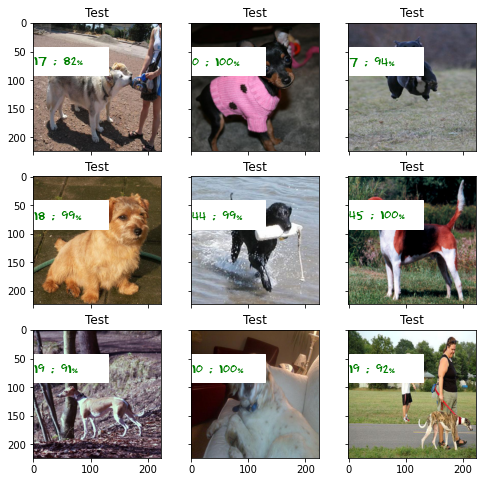

In [61]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8),
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_val = test_dataset[random_characters]
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 41),130,50,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn_1, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=13, color='green',fontweight='bold')

Получение предсказания

In [47]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [57]:
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))
print(test_files)
test_dataset = DogDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_cnn_1, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
print(test_filenames)

[PosixPath('/content/dogs/data/test/0.jpeg'), PosixPath('/content/dogs/data/test/1.jpeg'), PosixPath('/content/dogs/data/test/10.jpeg'), PosixPath('/content/dogs/data/test/100.jpeg'), PosixPath('/content/dogs/data/test/1000.jpeg'), PosixPath('/content/dogs/data/test/1001.jpeg'), PosixPath('/content/dogs/data/test/1002.jpeg'), PosixPath('/content/dogs/data/test/1003.jpeg'), PosixPath('/content/dogs/data/test/1004.jpeg'), PosixPath('/content/dogs/data/test/1005.jpeg'), PosixPath('/content/dogs/data/test/1006.jpeg'), PosixPath('/content/dogs/data/test/1007.jpeg'), PosixPath('/content/dogs/data/test/1008.jpeg'), PosixPath('/content/dogs/data/test/1009.jpeg'), PosixPath('/content/dogs/data/test/101.jpeg'), PosixPath('/content/dogs/data/test/1010.jpeg'), PosixPath('/content/dogs/data/test/1011.jpeg'), PosixPath('/content/dogs/data/test/1012.jpeg'), PosixPath('/content/dogs/data/test/1013.jpeg'), PosixPath('/content/dogs/data/test/1014.jpeg'), PosixPath('/content/dogs/data/test/1015.jpeg'), P

In [54]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,0.jpeg,42
1,1.jpeg,3
2,10.jpeg,39
3,100.jpeg,49
4,1000.jpeg,35


In [55]:
my_submit.to_csv('gdrive/My Drive/dogs_1.csv', index=False)

**Вывод** Лучшего качества классификации на небольшом датасете удалось добиться, используя fine-tuning - мощная базовая архитектура хорошо выделила признаки, общие для всех изображений, а после дообучения научилась видеть и более специфичные для конкретных данных признаки. В качестве основной сетки брала resnet, замораживала все веса, кроме весов последнего сверточного и линейного слоев и дообучала на датасете с собаками. Так как данных не очень много, увеличила датасет аугментациями. Учила в течение 15 эпох, для лучшего результата можно было поучить дольше, но времени уже не было(

Accuracy 0.844 на тестовом датасете

In [ ]:
# Your experiments here